In [48]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
import seaborn as sn
import atlas_mpl_style as ampl
ampl.use_atlas_style()  
import torch
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [49]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from imcal import *

In [50]:

#These are variables to change
CUT = True
LABELS = ["BH_n4_M10"]
PLOT_LABELS = ["BH_n4_M10"]
FOLDERS = ["BH"]

if CUT:
    VAL_N_EVENTS = [15000]
    N_MIN = 5
    ST_MIN = 7 #TeV
    ETA_MAX = 2.4
    PT_MIN = 70 #GeV

    VAL_CUT_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{folder}/50/{label}_test_res50_STmin7_Nmin5_3000_events.h5" for label, folder in zip(LABELS, FOLDERS)]
        
else:
    VAL_N_EVENTS = [3000]*len(LABELS)

DATA_PATH = "/disk/atlas3/data_MC/delphes/"

#Set data paths


VAL_FILENAMES = [f"{label}_{n}events.root" for label, n in zip(LABELS, VAL_N_EVENTS)]

VAL_DATAPATHS = [f"{DATA_PATH}/{VAL_FILENAME}" for VAL_FILENAME in VAL_FILENAMES]

DEVICE = torch.device("cpu")

In [51]:
def load_cut_event_numbers(hdf5file):
    with h5py.File(hdf5file, 'r') as f:
        keys = list(f.keys())
        data = [f[key]["event_id"] for key in keys]
        #create array
        ids = np.array(data).flatten()
        ids = ids.tolist()
        ids = [int(item[0]) for item in ids]
    return ids

In [52]:
#Open file in with-function will close it when you exit

def get_arrays(data_paths, n_events, id_paths=None):
    clusters = [load_data(f"{path}:Delphes", "Tower", 
                            ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"], n) for n, path in zip(n_events, data_paths)]
    
    tracks = [load_data(f"{path}:Delphes", "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    jets = [load_data(f"{path}:Delphes", "Jet", 
                            ["Jet.PT", "Jet.Eta", "Jet.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    event_numbers = [load_data(f"{path}:Delphes", "Event", 
                            ["Event.Number"], n) for n, path in zip(n_events, data_paths)]
    if CUT:
        cut_event_ids = [load_cut_event_numbers(id_path) for id_path in id_paths]    
        print(f"Events before cut: {[len(item) for item in clusters]}")
        event_ids = [ak.to_numpy(ar["Number"]).flatten() for ar in event_numbers]
        matching_ids = [np.argwhere(np.isin(ids, cut_ids)).ravel() for ids, cut_ids in zip(event_ids, cut_event_ids)]
        clusters = [item[ids] for item, ids in zip(clusters, matching_ids)]
        tracks = [item[ids] for item, ids in zip(tracks, matching_ids)]
        print(f"Events after cut: {[len(item) for item in clusters]}")

    return matching_ids, jets, clusters, tracks

if CUT:
    event_ids, jets, clusters, tracks = get_arrays(VAL_DATAPATHS, VAL_N_EVENTS, VAL_CUT_DATAPATHS)

else:
    event_ids, jets, clusters, tracks = get_arrays(VAL_DATAPATHS)

Events before cut: [15000]
Events after cut: [3000]


In [53]:
#Print some of the images
valpaths = [Path(path) for path in VAL_CUT_DATAPATHS]
inspect_data = Hdf5Dataset(valpaths, LABELS, DEVICE, max_value=5000, 
                        shuffle=False, filters=[None], transform=None, event_limit=1000)
#view_data(inspect_data, 3, len(valpaths), PLOT_LABELS, 50, VAL_N_EVENTS)

Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_3000_events.h5.
Selecting 1000 events out of 3000.


In [54]:
print(len(inspect_data))

1000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BH_n4_M10_test, not in ['BH_n4_M10']
Look at the highest histogram values values for a random image
[355.07455 356.44507 398.52005 420.0461  573.8182  624.4294  761.2194
 857.27405 876.9752 ]
Looking at event 2


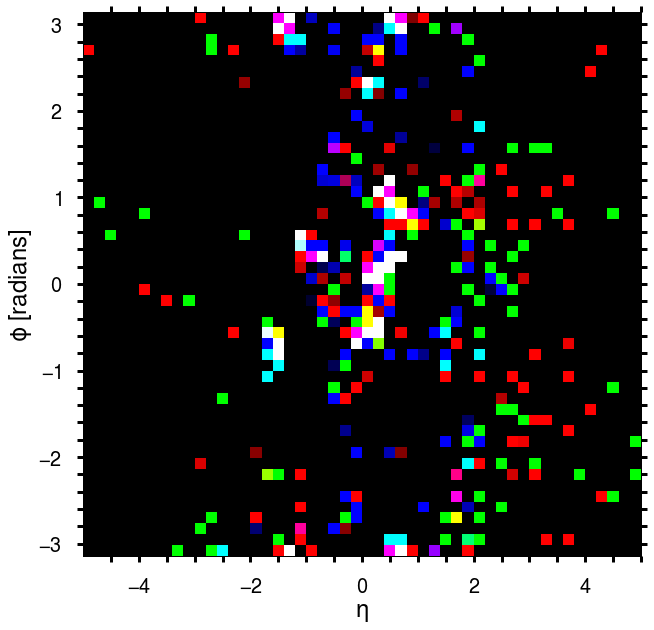

In [55]:
k = 0
id = event_ids[0][k]
image = inspect_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at event", id)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

In [56]:
max_hits = torch.Tensor([torch.max(image[:,:,i]) for i in range(0,3)])
norm_image = (image/max_hits)*1000
max_hits_norm = torch.Tensor([torch.max(norm_image[:,:,i]) for i in range(0,3)])
new_image = torch.arctan(torch.log(norm_image/10)/torch.pi) + 0.5

tensor([1000., 1000., 1000.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


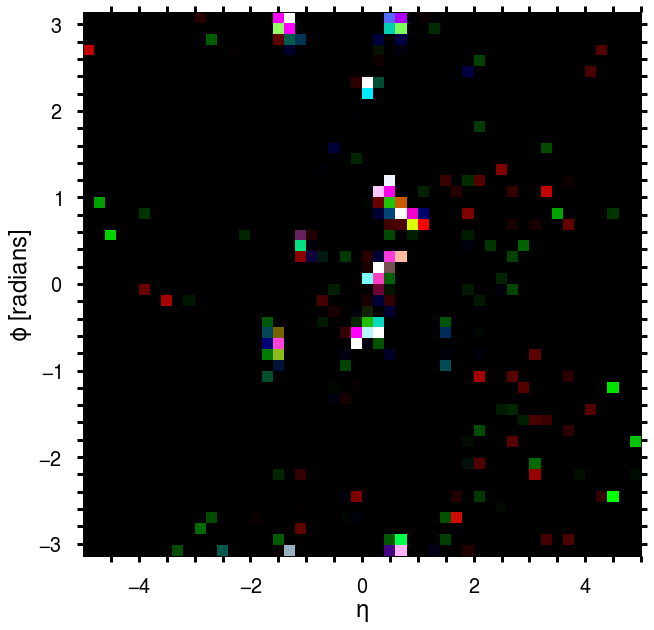

In [57]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(new_image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

In [58]:

print(len(clusters[0]['Ehad'][id]), len(clusters[0]['Eem'][id]), len(clusters[0]['Phi'][id]), len(clusters[0]['Eta'][id]))

246 246 246 246


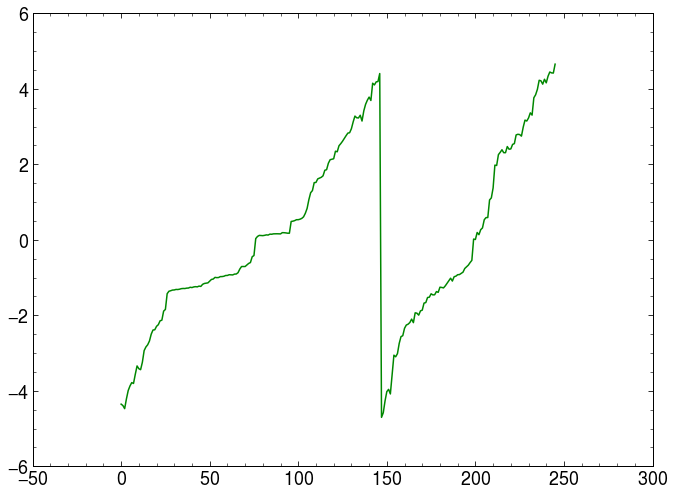

In [59]:
plt.plot(clusters[0]['Eta'][id])

In [60]:

np.set_printoptions(precision=5, suppress=True)
print("Ehad energy: \n")
print(f"{np.array(clusters[0]['Ehad'][id])}")
print("\n Eem energy: \n")
print(f"{np.array(clusters[0]['Eem'][id], dtype='float')}")
print("\n Eta: \n")
print(f"{np.array(clusters[0]['Eta'][id])}")
print("\n Phi: \n")
print(f"{np.array(clusters[0]['Phi'][id])}")
print("\n -------------- ")
print("-------------- \n")
print("\n Track energy: \n")
print(f"{np.array(tracks[0]['PT'][id])}")
print("\n Track Eta: \n")
print(f"{np.array(tracks[0]['Eta'][id])}")
print("\n Track Phi: \n")
print(f"{np.array(tracks[0]['Phi'][id])}")
 

Ehad energy: 

[   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.     

In [61]:


filename = f"{LABELS[0]}_eventid_{id}_cluster_values"
file = open(f"../results/{filename}.txt", "w")
file.write("Ehad energy: \n")
file.write(f"{np.array(clusters[0]['Ehad'][id])}")
file.write("\n Eem energy: \n")
file.write(f"{np.array(clusters[0]['Eem'][id], dtype='float')}")
file.write("\n Eta: \n")
file.write(f"{np.array(clusters[0]['Eta'][id])}")
file.write("\n Phi: \n")
file.write(f"{np.array(clusters[0]['Phi'][id])}")
file.write("\n -------------- ")
file.write("-------------- \n")
file.write("\n Track energy: \n")
file.write(f"{np.array(tracks[0]['PT'][id])}")
file.write("\n Track Eta: \n")
file.write(f"{np.array(tracks[0]['Eta'][id])}")
file.write("\n Track Phi: \n")
file.write(f"{np.array(tracks[0]['Phi'][id])}")

file.close()

    